As a best practice, OpenFF software attempts to associate explicit units with numerical values. At times this seems overly cautious, but mistakes with units have caused crashes of everything from molecular simulations on silicon to [expensive rockets](https://en.wikipedia.org/wiki/Mars_Climate_Orbiter#Cause_of_failure) on Mars.

Units are tagged using the [`openff-units`](https://github.com/openforcefield/openff-units#openff-units) package, which provides numerical types associated with commonly used units and methods for ergonomically and safely converting between units. It is based on [Pint](https://github.com/hgrecco/pint), which behaves similarly to OpenMM's unit package.

In [1]:
from openff.units import unit, Quantity

bond_length = Quantity(0.145, unit.nanometer)
bond_length

0.145 <Unit('nanometer')>

As a shorthand, you can create `Quantity` objects by multiplying numerical objects (int, float, `numpy.ndarray`, etc.) by a `unit.Unit` object, i.e.:

In [2]:
value1 = Quantity(0.8, unit.kilocalorie_per_mole)
value2 = 0.8 * unit.kilocalorie_per_mole

assert value1 == value2

value1, value2

(0.8 <Unit('kilocalorie_per_mole')>, 0.8 <Unit('kilocalorie_per_mole')>)

The `Quantity` class is provided by this `unit` namespace (and re-exported at the top-level `openff.units` module) so you will sometimes see it written as `unit.Quantity`:

In [3]:
assert Quantity(0.5, unit.kilojoule_per_mole) == unit.Quantity(0.5, unit.kilojoule_per_mole)
assert Quantity is unit.Quantity

These objects support conversion to other units via `Quantity.to()`, which takes another (compatible) unit as an argument:

In [4]:
bond_length.to(unit.angstrom)

1.45 <Unit('angstrom')>

These objects can be converted to unitless representation as-is via `Quantity.magnitude` (or its alias `Quantity.m`) or with an added conversion via `Quantity.m_as`.

In [5]:
bond_length.magnitude, bond_length.m_as(unit.angstrom), bond_length.m_as(unit.nanometer)

(0.145, 1.45, 0.145)

Scalar quantities can be serialized to strings using the built-in `str()` function and deserialized using the `Quantity` constructor. This is handy for reading and writing things like force fields - this is how OpenFF Toolkit interacts with SMIRNOFF (`.offxml`) force field files on disk.

In [6]:
k = 10 * unit.kilocalorie / unit.mol / unit.nanometer**2
str(k)

'10.0 kilocalorie / mole / nanometer ** 2'

In [7]:
Quantity(str(k))

10.0 <Unit('kilocalorie / mole / nanometer ** 2')>

<div class="alert alert-warning" style="max-width: 700px; margin-left: auto; margin-right: auto;">
    ⚠️ <b> OpenFF and OpenMM unit packages are not directly interoperable!</b><br />
Passing <code>openff.units.Quantity</code> objects to the OpenMM API, or vice versa, may fail or silently produce surprising results such as stripping units without warning. Mixing objects from different unit packages (i.e. atomic positions represented by a combination of both objects) can also lead to confusing error messages.
</div>

For [compatibility with OpenMM units](https://github.com/openforcefield/openff-units#openmm-interoperability), a submodule (`openff.units.openmm`) with conversion functions (to_openmm, from_openmm) is also provided.

In [8]:
from openff.units.openmm import from_openmm, to_openmm

distance = 4.0 * unit.femtosecond
converted = to_openmm(distance)
converted, type(converted)

(Quantity(value=4.0, unit=femtosecond), openmm.unit.quantity.Quantity)

In [9]:
roundtripped = from_openmm(converted)
roundtripped, type(roundtripped)

(4.0 <Unit('femtosecond')>, pint.util.Quantity)

For cases in which a quantity might be _either_ an `openff.units.Quantity` or `openmm.unit.Quantity`, a helper function `ensure_quantity` is provided to safely converted either into a specified type. Physically equivalent values provided by either units package should be processed into the same results if provided. The variables `distance`, `converted`, and `roundtripped` that we just made can be coerced into equivalent objects if requested.

In [10]:
from openff.units.openmm import ensure_quantity

?ensure_quantity

Signature:
ensure_quantity(
    unknown_quantity: Union[pint.util.Quantity, ForwardRef('openmm_unit.Quantity')],
    type_to_ensure: Literal['openmm', 'openff'],
) -> Union[pint.util.Quantity, ForwardRef('openmm_unit.Quantity')]
Docstring:
Given a quantity that could be of a variety of types, attempt to coerce into a given type.

Examples
--------

>>> import numpy
>>> from openmm import unit as openmm_unit
>>> from openff.units import unit
>>> from openff.units.openmm import ensure_quantity
>>> # Create a 9 Angstrom quantity with each registry
>>> length1 = unit.Quantity(9.0, unit.angstrom)
>>> length2 = openmm_unit.Quantity(9.0, openmm_unit.angstrom)
>>> # Similar quantities are be coerced into requested type
>>> assert type(ensure_quantity(length1, "openmm")) == openmm_unit.Quantity
>>> assert type(ensure_quantity(length2, "openff")) == unit.Quantity
>>> # Seemingly-redundant "conversions" short-circuit
>>> assert ensure_quantity(length1, "openff") == ensure_quantity(length2, "openf

In [11]:
type(ensure_quantity(distance, "openff")), type(ensure_quantity(distance, "openmm"))

(pint.util.Quantity, openmm.unit.quantity.Quantity)

In [12]:
assert ensure_quantity(distance, "openmm") == ensure_quantity(converted, "openmm")
assert ensure_quantity(distance, "openff") == ensure_quantity(converted, "openff")

An effort is made to convert from OpenMM constructs, such as converting `List[openmm.Vec3]` to wrapped NumPy arrays:

In [13]:
import openmm.app

positions = openmm.app.PDBFile("../pdb/MainChain_ALA.pdb").getPositions()
type(positions), positions

(openmm.unit.quantity.Quantity,
 Quantity(value=[Vec3(x=2.595, y=2.5179, z=2.4582), Vec3(x=2.5986000000000002, y=2.6176, z=2.4145000000000003), Vec3(x=2.5332000000000003, y=2.6843000000000004, z=2.4703), Vec3(x=2.5673, y=2.6131, z=2.3104), Vec3(x=2.7405000000000004, y=2.6691000000000003, z=2.4218), Vec3(x=2.8285, y=2.5999, z=2.4713000000000003), Vec3(x=2.7621, y=2.7909, z=2.3728000000000002), Vec3(x=2.6838, y=2.8435, z=2.337), Vec3(x=2.8916000000000004, y=2.8589, z=2.373), Vec3(x=2.9471000000000003, y=2.8288, z=2.462), Vec3(x=2.971, y=2.8153, z=2.2489000000000003), Vec3(x=2.9172000000000002, y=2.8440000000000003, z=2.1584), Vec3(x=3.0691, y=2.8627000000000002, z=2.2488), Vec3(x=2.9844000000000004, y=2.7070000000000003, z=2.2499), Vec3(x=2.8737, y=3.0119000000000002, z=2.3778), Vec3(x=2.7675, y=3.0634, z=2.3428999999999998), Vec3(x=2.9784, y=3.0841000000000003, z=2.4197), Vec3(x=3.0622000000000003, y=3.0348, z=2.4461), Vec3(x=2.9784, y=3.23, z=2.4293), Vec3(x=2.8951000000000002, y=3.262

In [14]:
converted = from_openmm(positions)
type(converted), type(converted.m), converted

(pint.util.Quantity,
 numpy.ndarray,
 array([[2.595 , 2.5179, 2.4582],
        [2.5986, 2.6176, 2.4145],
        [2.5332, 2.6843, 2.4703],
        [2.5673, 2.6131, 2.3104],
        [2.7405, 2.6691, 2.4218],
        [2.8285, 2.5999, 2.4713],
        [2.7621, 2.7909, 2.3728],
        [2.6838, 2.8435, 2.337 ],
        [2.8916, 2.8589, 2.373 ],
        [2.9471, 2.8288, 2.462 ],
        [2.971 , 2.8153, 2.2489],
        [2.9172, 2.844 , 2.1584],
        [3.0691, 2.8627, 2.2488],
        [2.9844, 2.707 , 2.2499],
        [2.8737, 3.0119, 2.3778],
        [2.7675, 3.0634, 2.3429],
        [2.9784, 3.0841, 2.4197],
        [3.0622, 3.0348, 2.4461],
        [2.9784, 3.23  , 2.4293],
        [2.8951, 3.2628, 2.4918],
        [3.072 , 3.2652, 2.4729],
        [2.9663, 3.2734, 2.3299]]) <Unit('nanometer')>)

The OpenFF Toolkit uses `openff.units` for handling unit-bearing quantities as of release 0.11.0 (August 2022).

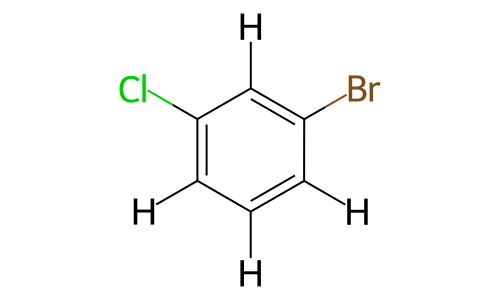

In [15]:
from openff.toolkit import Molecule, __version__
from packaging.version import Version

assert Version(__version__) >= Version("0.11")

molecule = Molecule.from_smiles("c1ccc(Br)cc1Cl")
molecule

In [16]:
molecule.generate_conformers(n_conformers=1)
molecule.assign_partial_charges(partial_charge_method="am1bcc")
type(molecule.conformers[0]), type(molecule.partial_charges)

(pint.util.Quantity, pint.util.Quantity)

In [17]:
molecule.conformers

[array([[ 1.8851409 , -1.0363065 , -0.11244039],
        [ 2.92100501, -1.63086545,  0.60814351],
        [ 2.87828588, -1.65199244,  2.00218749],
        [ 1.79970002, -1.07863986,  2.67567587],
        [ 1.74158669, -1.10938549,  4.56459284],
        [ 0.76382941, -0.48413831,  1.95505464],
        [ 0.80655617, -0.46301064,  0.56100631],
        [-0.47163486,  0.26944932, -0.32898274],
        [ 1.93170583, -1.02738023, -1.19841552],
        [ 3.76074195, -2.07713771,  0.08337314],
        [ 3.69403815, -2.11841393,  2.54832172],
        [-0.07850236, -0.0369442 ,  2.4785912 ]]) <Unit('angstrom')>]

<div class="alert alert-info" style="max-width: 700px; margin-left: auto; margin-right: auto;">
ℹ️ Tip: If using OpenFF tools alongside OpenMM, it is useful to import their different units solutions with different names. Avoid importing both as <code>unit</code> in order to keep them separate in your workspace.</div>

In [18]:
from openff.units import unit
import openmm.unit

In [19]:
type(unit.angstrom * 1.2), type(openmm.unit.angstrom * 1.2)

(pint.util.Quantity, openmm.unit.quantity.Quantity)